In [18]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import tqdm

In [19]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [20]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [21]:
RESULTS_ROOT = pyprojroot.here() / 'results' / 'Bengalese_Finches' / 'learncurve'

### Figure

values from Okanoya paper below (`KOUMURA_OKANOYA_NOTE_ERROR_RATES`) are taken from this table:
[https://doi.org/10.1371/journal.pone.0159188.t001](https://doi.org/10.1371/journal.pone.0159188.t001)

Their "note error rate" is what we call "segment error rate".
We chose the values from their models that achieved the lowest error rate.

In [22]:
sns.set("paper")

In [23]:
# max width in inches is 7.5
# https://journals.plos.org/ploscompbiol/s/figures
FIGSIZE = (7.5, 3.75)
DPI = 300


def plot_error_across_birds_curve(curve_df, 
                                  suptitle=None, 
                                  ax1_ylim=(0, 8),
                                  ax2_ylim=(0.1, 0.65),
                                  save_fig=False):
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    fig = plt.figure(constrained_layout=True, figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(nrows=4, ncols=2, hspace=0.005)

    ax_arr = []
    ax_arr.append(fig.add_subplot(gs[0, 0]))
    ax_arr.append(fig.add_subplot(gs[1:, 0]))
    ax_arr.append(fig.add_subplot(gs[:, 1]))

    ax_arr = np.asarray(ax_arr)
    ax_arr[0].get_shared_x_axes().join(*ax_arr[:2].tolist())

    #for col in range(2):
    ax_arr[0].spines['bottom'].set_visible(False)
    ax_arr[1].spines['top'].set_visible(False)
    ax_arr[1].xaxis.tick_bottom()

    metric_list = ['avg_error', 'avg_segment_error_rate']
    ylabels = ['Frame error (%)', 'Segment error rate\n(edits per segment)']


    for col, (metric, ylabel) in enumerate(zip(metric_list, ylabels)):
        if col == 0:
            ax = ax_arr[1]
        else:
            ax = ax_arr[2]

        if col == 1:
            legend = 'full'
        else:
            legend = False

        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     hue='animal_id', 
                     data=curve_df,
                     ci='sd',
                     palette='colorblind',
                     linewidth=2, 
                     ax=ax, 
                     legend=legend)
        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     linestyle='dashed', 
                     color='k', 
                     linewidth=4, 
                     data=curve_df, ci=None, label='mean', ax=ax, legend=legend)

        ax.set_ylabel('')

        ax.set_xlabel('Training set duration (s)', fontsize=10)
        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)


    ax_arr[0].set_xticklabels([])
    ax_arr[0].set_xlabel('')

    # zoom-in / limit the view to different portions of the data
    ax_arr[0].set_ylim(40, 100)
    # ax_arr[1, 0].set_ylim(0, 14)
    ax_arr[1].set_ylim(ax1_ylim)
    ax_arr[2].set_ylim(ax2_ylim)        

    bigax_col0 = fig.add_subplot(gs[:, 0], frameon=False)
    bigax_col1 = fig.add_subplot(gs[:, 1], frameon=False)
    labelpads = (2, 10)
    panel_labels = ['A', 'B']
    for ylabel, labelpad, panel_label, ax in zip(ylabels,
                                                 labelpads,
                                                 panel_labels,
                                                 [bigax_col0, bigax_col1]):
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax.grid(False)
        ax.set_ylabel(ylabel, fontsize=10, labelpad=labelpad)
        ax.text(-0.2, 1., panel_label, transform=ax.transAxes,
              fontsize=12, fontweight='bold', va='top', ha='right')

    # get handles from right axes legend, then remove and re-create outside
    handles, _ = ax_arr[2].get_legend_handles_labels()
    # [ha.set_linewidth(2) for ha in handles ]
    ax_arr[2].get_legend().remove()
    bigax_col1.legend(handles=handles, bbox_to_anchor=(1.35, 1))

    fig.set_constrained_layout_pads(hspace=-0.05, wspace=0.0)
    
    if suptitle is not None:
        fig.suptitle(suptitle)

We plot learning curves after re-running the submitted experiments using **spectrograms generated with the default parameters**. These curves look like the [submitted results](src/scripts/BirdsongRecognition/initial_submission/error-across-birds-figure.ipynb).

In [24]:
error_csv_path = RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)

In [25]:
curve_df.columns

Index(['cleanup', 'avg_acc', 'avg_levenshtein', 'avg_pct_boundary_err',
       'avg_segment_error_rate', 'train_set_dur', 'replicate_num',
       'model_name', 'avg_error', 'animal_id', 'train_set_dur_ind'],
      dtype='object')

In [26]:
gb = curve_df.groupby(['cleanup', 'train_set_dur'])

In [27]:
df = gb.agg(['mean'])
df = df.reset_index()

In [28]:
df[df.cleanup == 'majority_vote']

,cleanup,train_set_dur,avg_acc,avg_levenshtein,avg_pct_boundary_err,avg_segment_error_rate,replicate_num,avg_error,train_set_dur_ind
,,,mean,mean,mean,mean,mean,mean,mean
0,majority_vote,30,0.970804,5.486573,0.625764,0.081680,5.5,2.919598,0
1,majority_vote,45,0.974073,4.982998,0.665659,0.074239,5.5,2.592712,1
2,majority_vote,75,0.976933,4.213997,0.708132,0.062044,5.5,2.306747,2
3,majority_vote,120,0.979544,3.207852,0.735199,0.049887,5.5,2.045578,3
4,majority_vote,180,0.980676,2.902139,0.752064,0.044881,5.5,1.932427,4
5,majority_vote,480,0.983728,1.942175,0.798035,0.030921,5.5,1.627153,5
6,majority_vote,600,0.984024,1.982343,0.798384,0.031390,5.5,1.597600,6


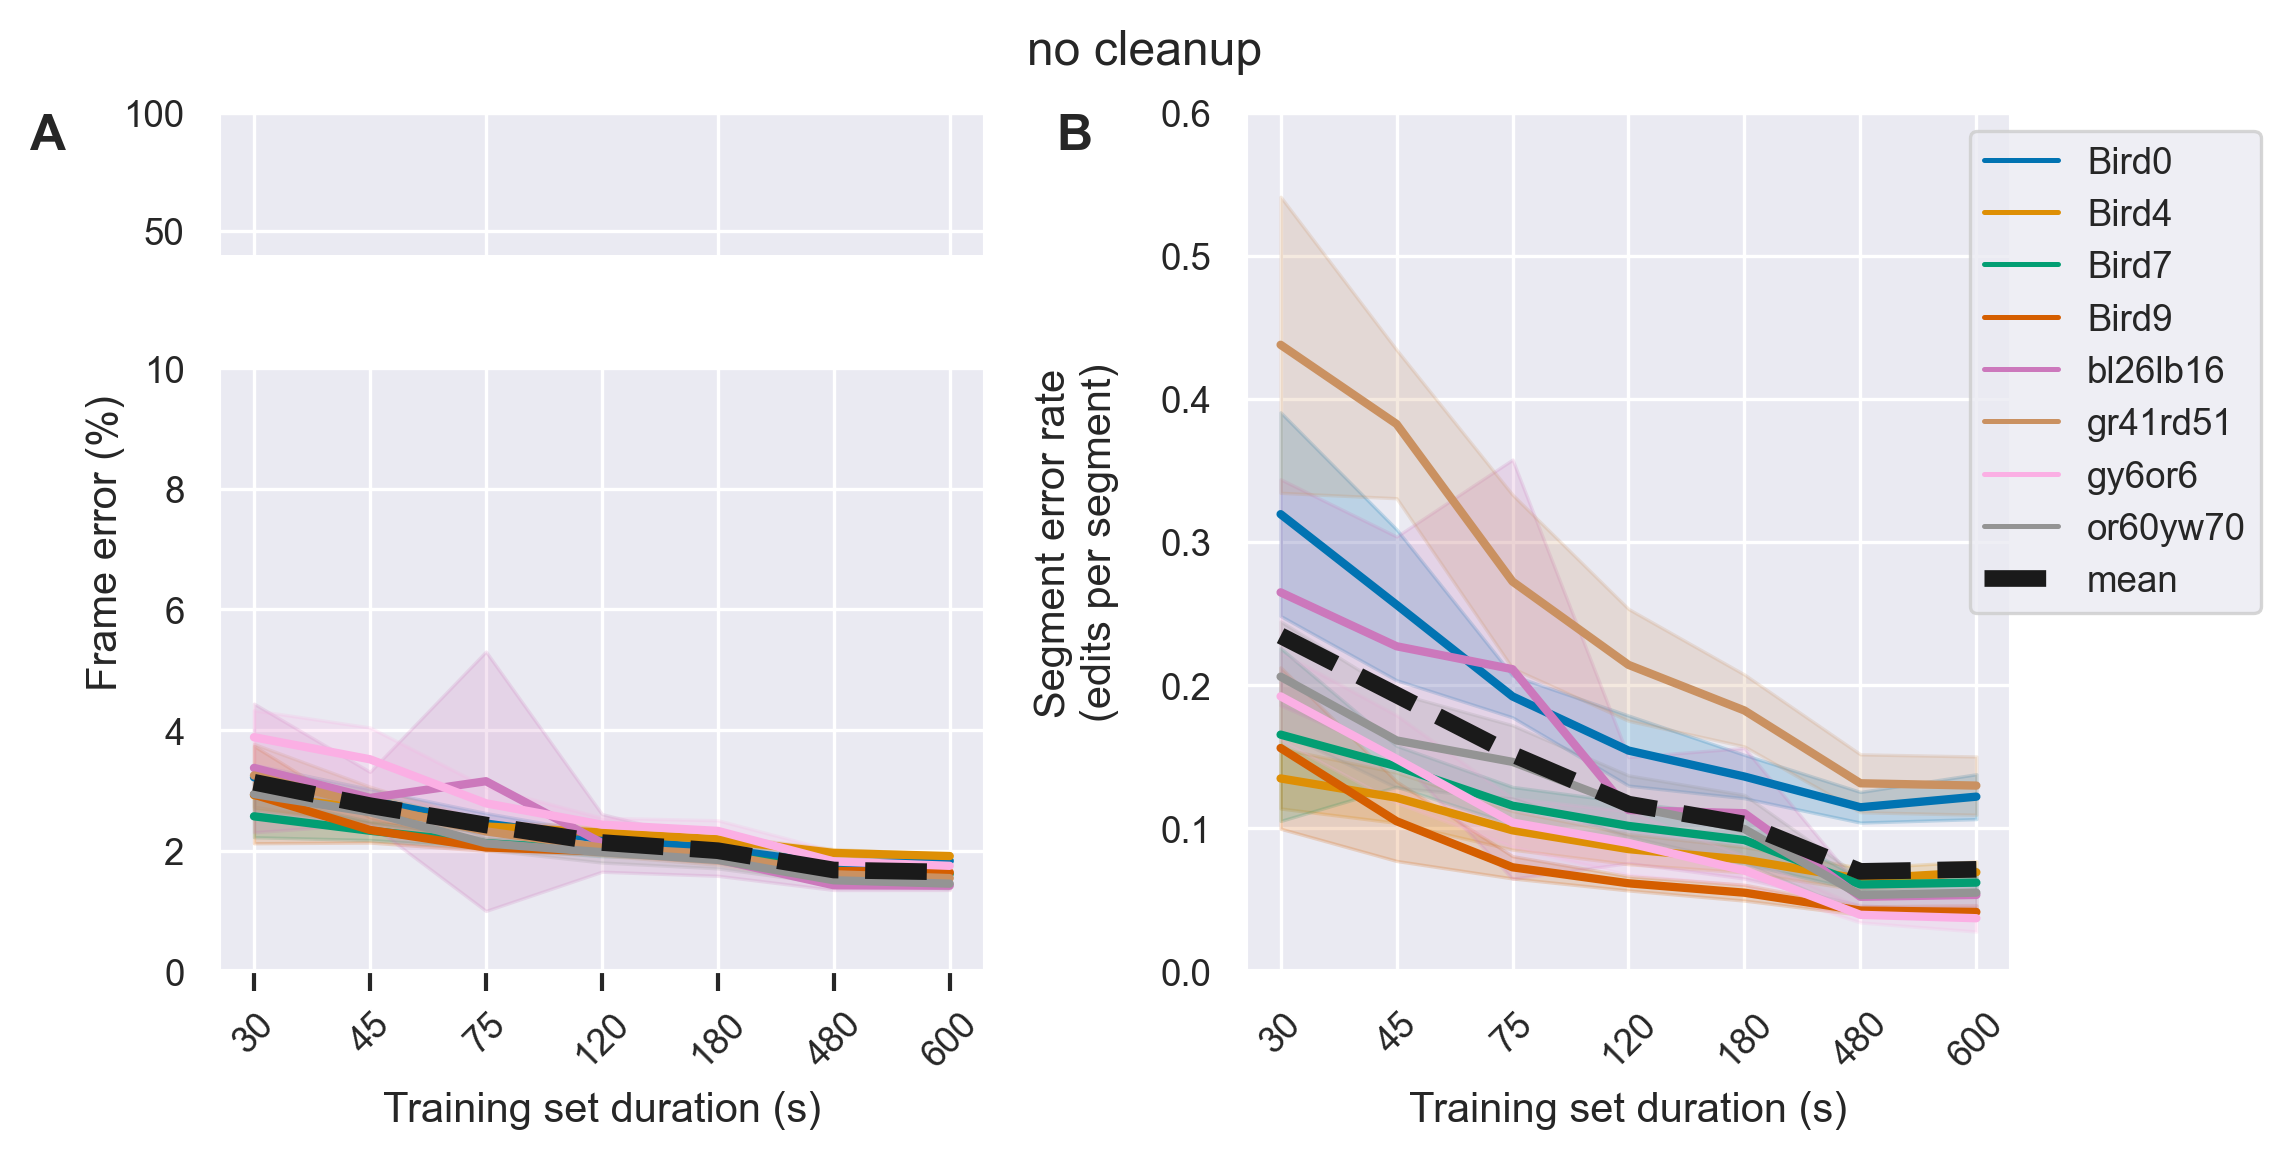

In [29]:
curve_df_cleanup_none = curve_df[curve_df.cleanup == 'none']
plot_error_across_birds_curve(curve_df_cleanup_none, 
                              suptitle=f'no cleanup',
                              ax1_ylim=(0,10),
                              ax2_ylim=(0., 0.6))

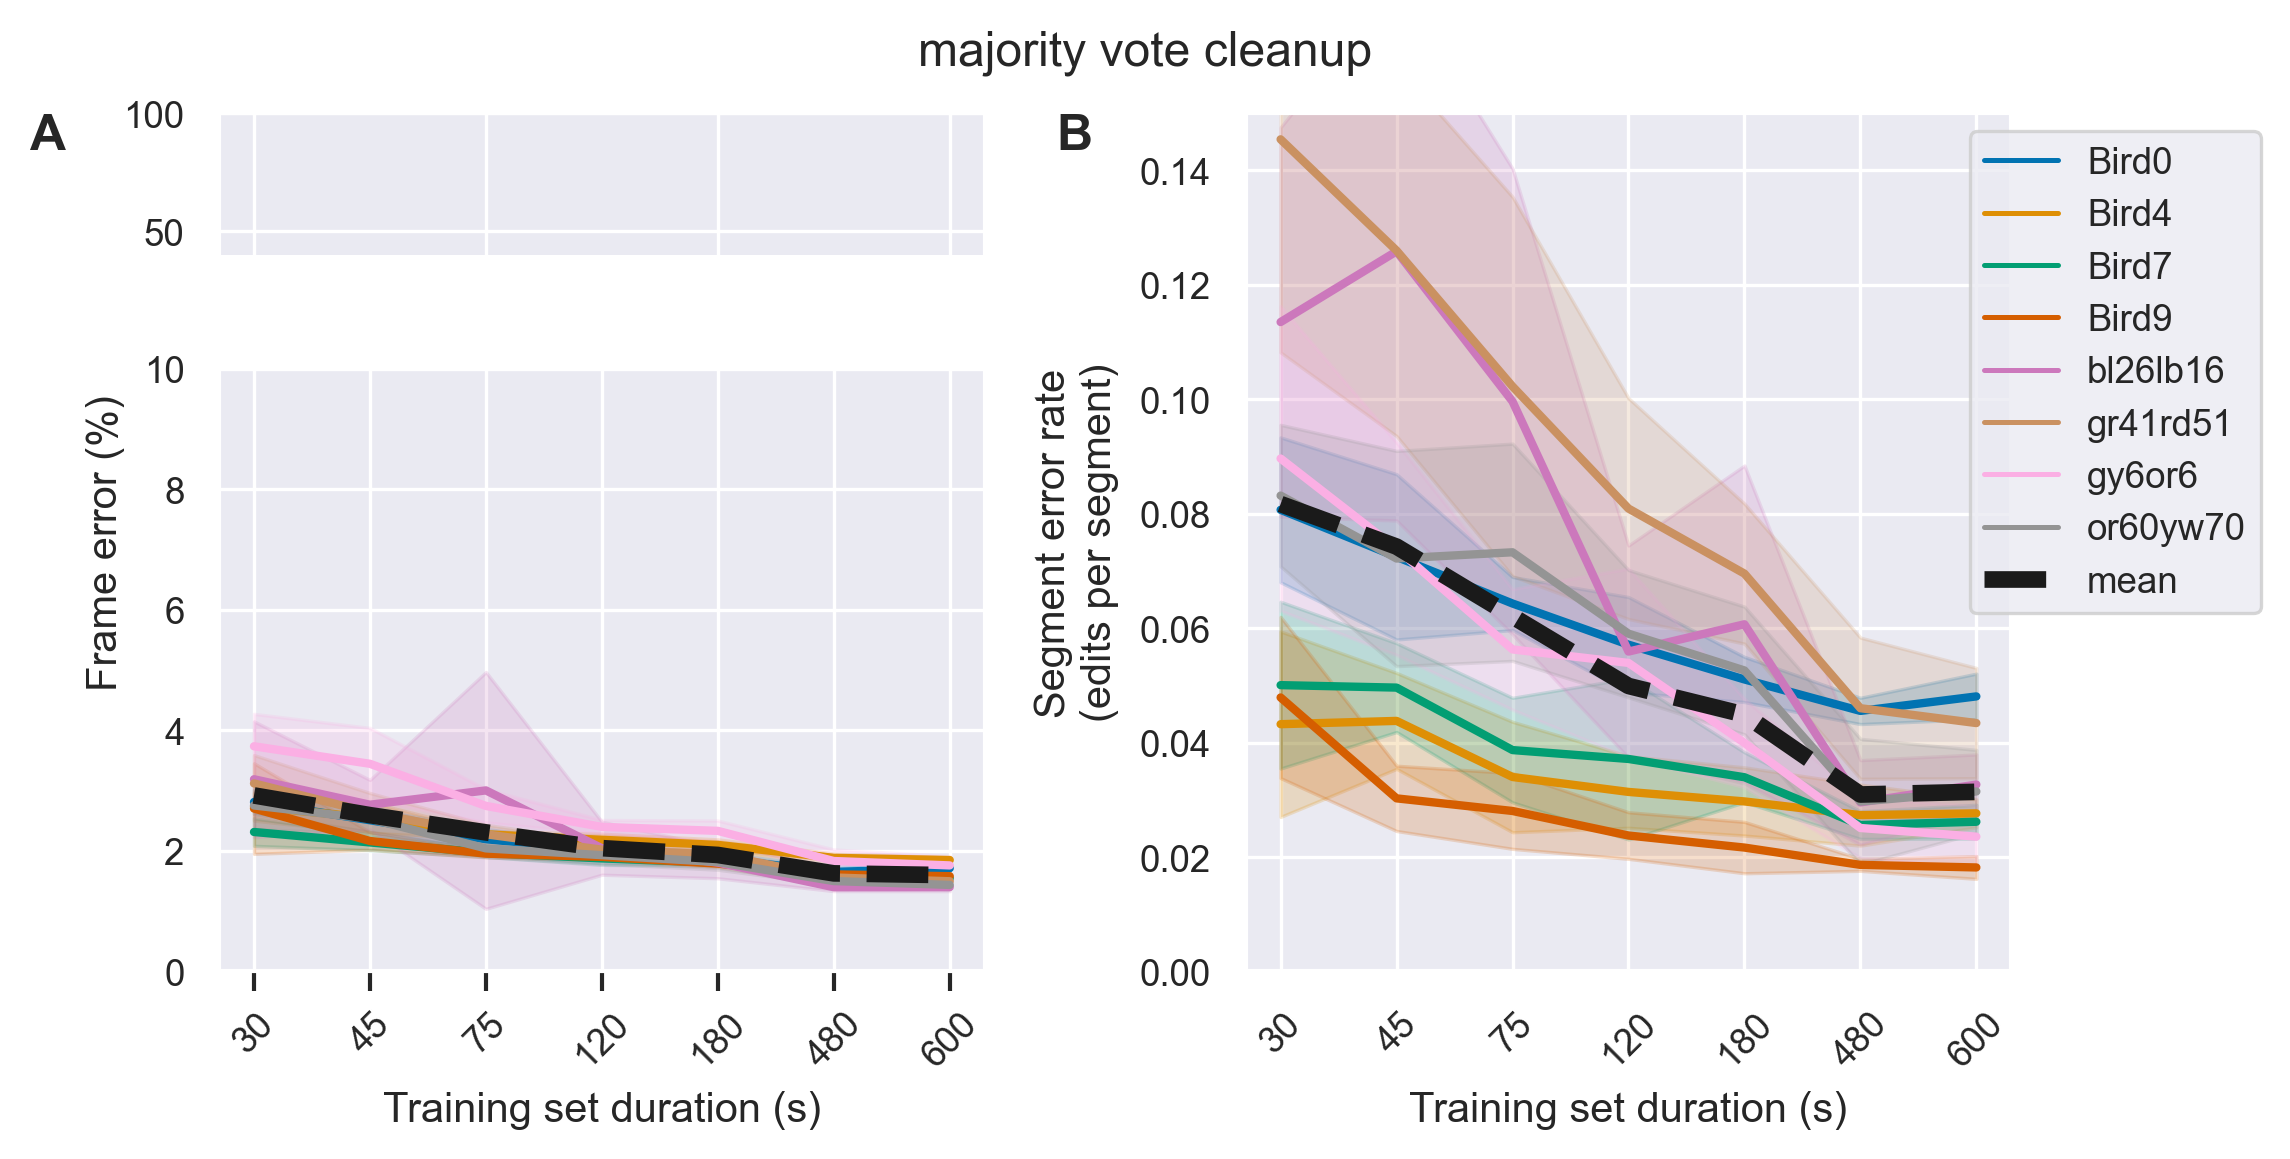

In [30]:
curve_df_cleanup_mv = curve_df[curve_df.cleanup == 'majority_vote']
plot_error_across_birds_curve(curve_df_cleanup_mv, 
                              suptitle='majority vote cleanup',
                              ax1_ylim=(0,10),
                              ax2_ylim=(0., 0.15))

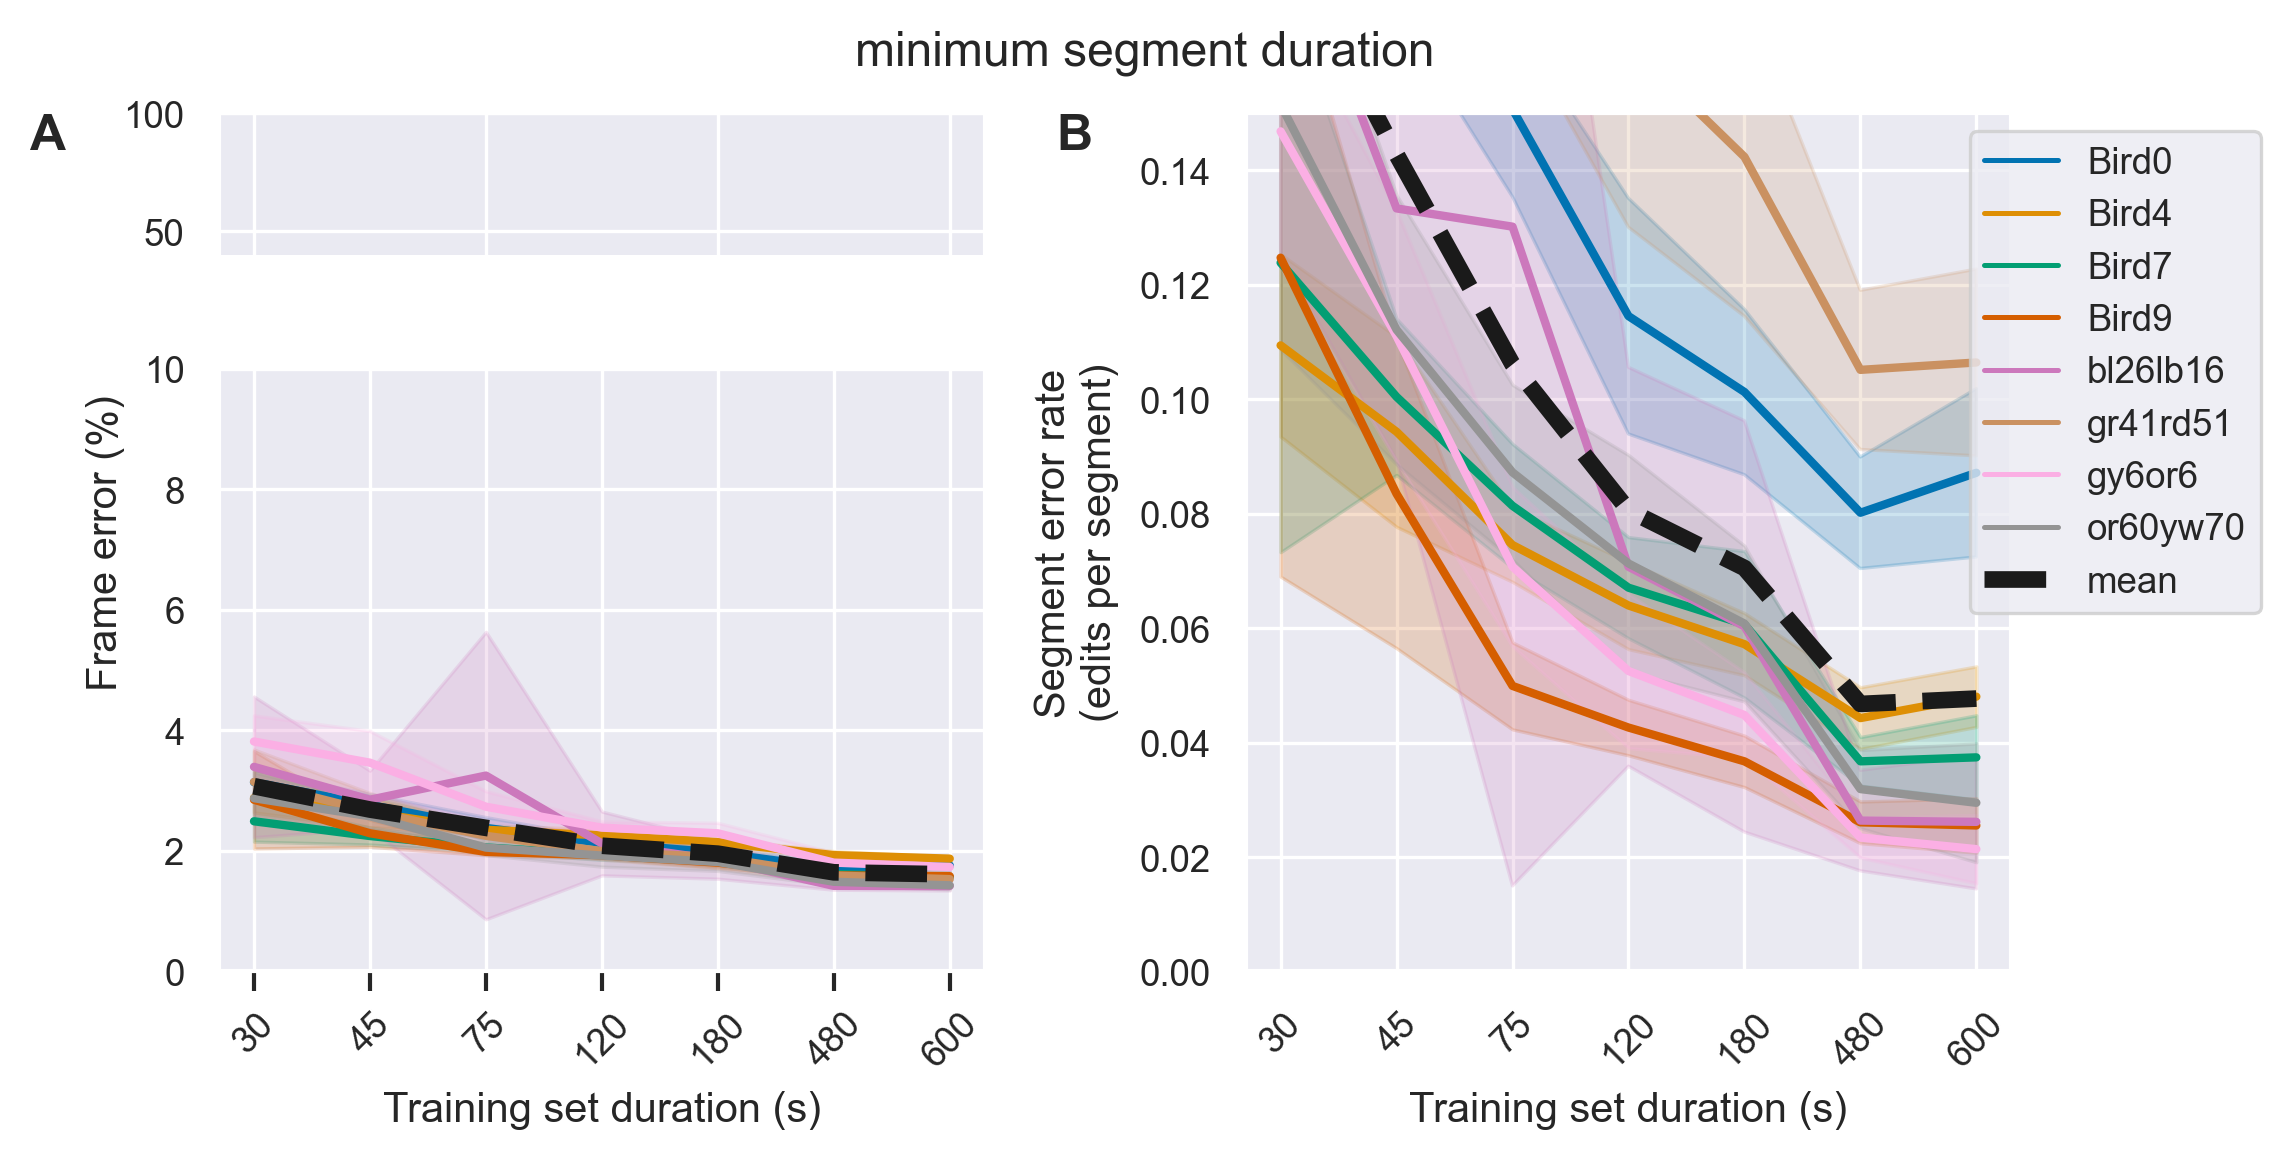

In [31]:
curve_df_cleanup_mv = curve_df[curve_df.cleanup == 'min_segment_dur']
plot_error_across_birds_curve(curve_df_cleanup_mv, 
                              suptitle='minimum segment duration',
                              ax1_ylim=(0,10),
                              ax2_ylim=(0., 0.15))

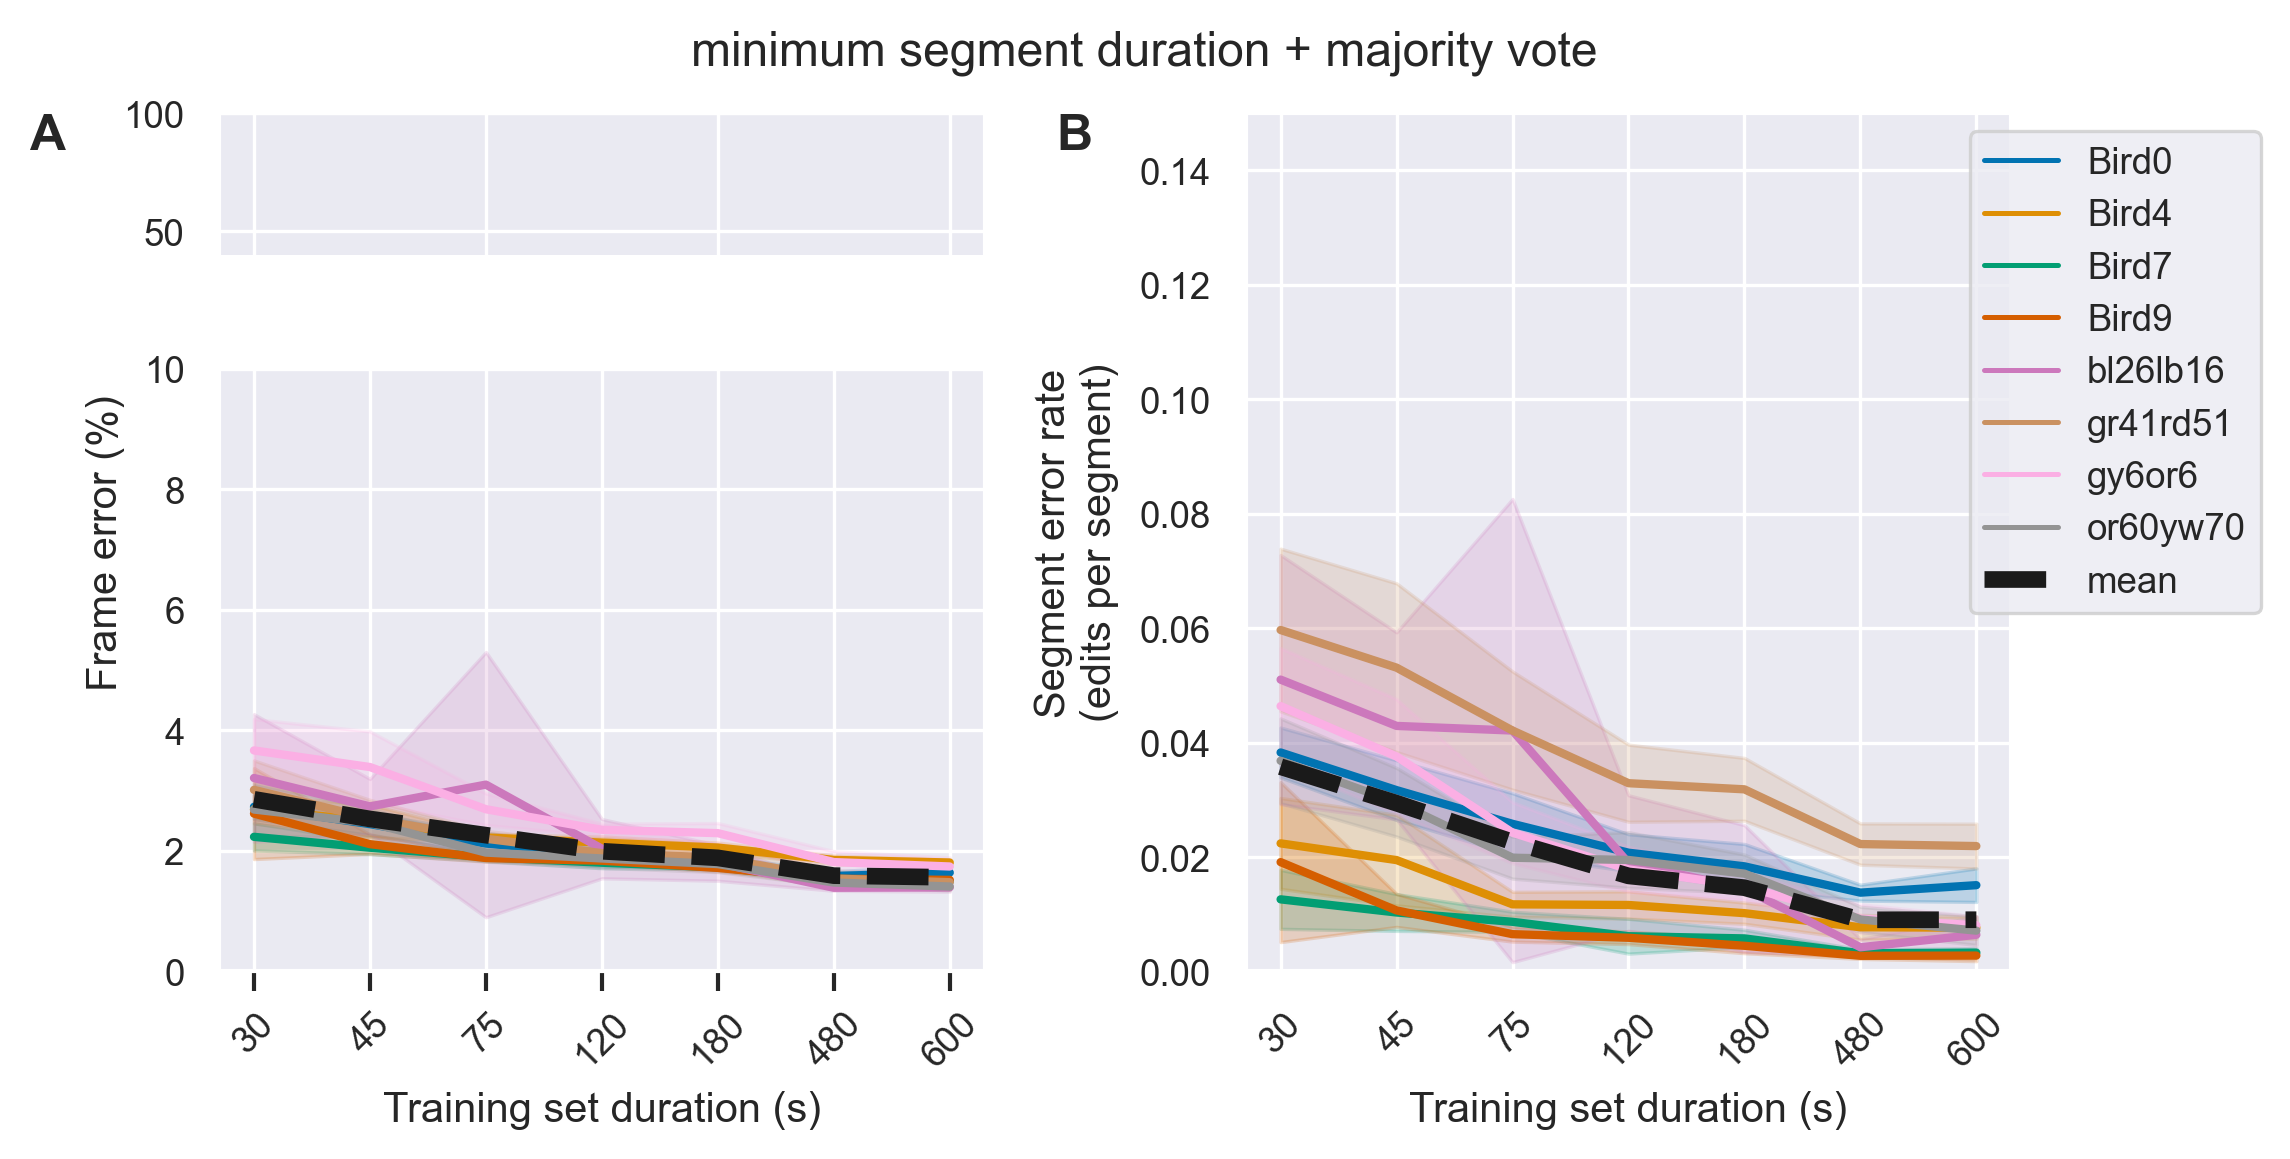

In [17]:
curve_df_cleanup_mv = curve_df[curve_df.cleanup == 'min_segment_dur_majority_vote']
plot_error_across_birds_curve(curve_df_cleanup_mv, 
                              suptitle='minimum segment duration + majority vote',
                              ax1_ylim=(0,10),
                              ax2_ylim=(0., 0.15))